In [2]:
import pandas as pd

df = pd.read_excel(r"C:/Users/avinashsharma01/Downloads/______.xlsx")
df.head()

,年份,时间,温度,湿度,地面辐射强度,大气上层辐射强度,光伏发电
0,2019-12-01 00:00:00,1,-10.687,0.001,0.0,0.0,0.0
1,2019-12-01 01:00:00,2,-10.623,0.001,0.0,0.0,0.0
2,2019-12-01 02:00:00,3,-10.564,0.001,0.0,0.0,0.0
3,2019-12-01 03:00:00,4,-10.954,0.001,0.0,0.0,0.0
4,2019-12-01 04:00:00,5,-11.344,0.001,0.0,0.0,0.0


In [3]:
df.columns

Index(['年份', '时间', '温度', '湿度', '地面辐射强度', '大气上层辐射强度', '光伏发电'], dtype='object')

In [4]:
df = df.rename(columns={
    '年份': 'timestamp',
    '时间': 'hour_index',
    '温度': 'temperature',
    '湿度': 'humidity',
    '地面辐射强度': 'irradiance_ground',
    '大气上层辐射强度': 'irradiance_atmos',
    '光伏发电': 'power'
})

In [5]:
df.columns

Index(['timestamp', 'hour_index', 'temperature', 'humidity',
       'irradiance_ground', 'irradiance_atmos', 'power'],
      dtype='object')

In [6]:
df.describe()

,timestamp,hour_index,temperature,humidity,irradiance_ground,irradiance_atmos,power
count,2152,2152.00000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000
mean,2019-05-21 05:17:03.791821568,1076.50000,-16.658232,0.000915,81.044739,135.710883,721.235507
min,2019-01-01 08:00:00,1.00000,-33.461000,0.000000,0.000000,0.000000,0.000000
25%,2019-01-23 17:45:00,538.75000,-20.721000,0.001000,0.000000,0.000000,0.000000
50%,2019-02-15 03:30:00,1076.50000,-17.337500,0.001000,0.000000,0.000000,0.000000
75%,2019-12-09 13:15:00,1614.25000,-12.938250,0.001000,132.453000,271.388750,918.278250
max,2019-12-31 23:00:00,2152.00000,2.636000,0.003000,585.033000,769.951000,4500.000000
std,NaN,621.37321,6.056661,0.000551,133.771757,205.929457,1237.513954


In [7]:
df.dtypes

timestamp            datetime64[ns]
hour_index                    int64
temperature                 float64
humidity                    float64
irradiance_ground           float64
irradiance_atmos            float64
power                       float64
dtype: object

In [8]:
df['ds'] = pd.to_datetime(df['timestamp'], format="%d-%m-%Y %H:%M", dayfirst=True, errors='coerce')
df.loc[df['ds'].dt.month == 12, 'ds'] -= pd.DateOffset(years=1)

In [9]:
df = df.drop(columns=['timestamp', 'hour_index'])
df = df.rename(columns={'power': 'y'})
df = df.sort_values('ds').reset_index(drop=True)

In [10]:
df['gap'] = df['ds'].diff().dt.total_seconds()/3600
print(df['gap'].describe())

count    2151.000000
mean        1.003719
std         0.172492
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: gap, dtype: float64


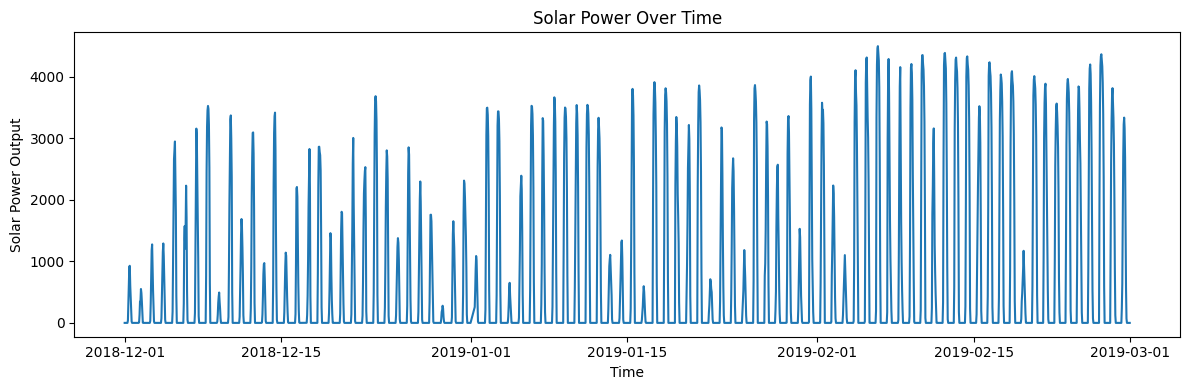

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(df['ds'], df['y'])
plt.xlabel('Time')
plt.ylabel('Solar Power Output')
plt.title('Solar Power Over Time')
plt.tight_layout()
plt.show()

In [12]:
df_model = df[['ds', 'y', 'temperature', 'humidity',
               'irradiance_ground', 'irradiance_atmos']].copy()

In [13]:
split = int(len(df_model) * 0.8)
train_df = df_model.iloc[:split]
test_df = df_model.iloc[split:]
print(train_df.shape, test_df.shape)

(1721, 6) (431, 6)


In [18]:
from prophet import Prophet

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.85
)

for col in ['temperature', 'humidity', 'irradiance_ground', 'irradiance_atmos']:
    model.add_regressor(col)

model.fit(train_df)


16:00:51 - cmdstanpy - INFO - Chain [1] start processing
16:00:56 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future_test = test_df[['ds', 'temperature', 'humidity',
                       'irradiance_ground', 'irradiance_atmos']]

forecast = model.predict(future_test)
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2019-02-11 01:00:00,-4.206070
1,2019-02-11 02:00:00,3.155367
2,2019-02-11 03:00:00,-97.996559
3,2019-02-11 04:00:00,-192.169214
4,2019-02-11 05:00:00,-122.502428


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
day_mask = y_true > 0
mape_daytime = np.mean(np.abs((y_true[day_mask] - y_pred[day_mask]) 
                              / y_true[day_mask])) * 100

print("Daytime MAPE:", mape_daytime)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Daytime MAPE: 123.32855453796768
MAE: 493.19
RMSE: 623.40


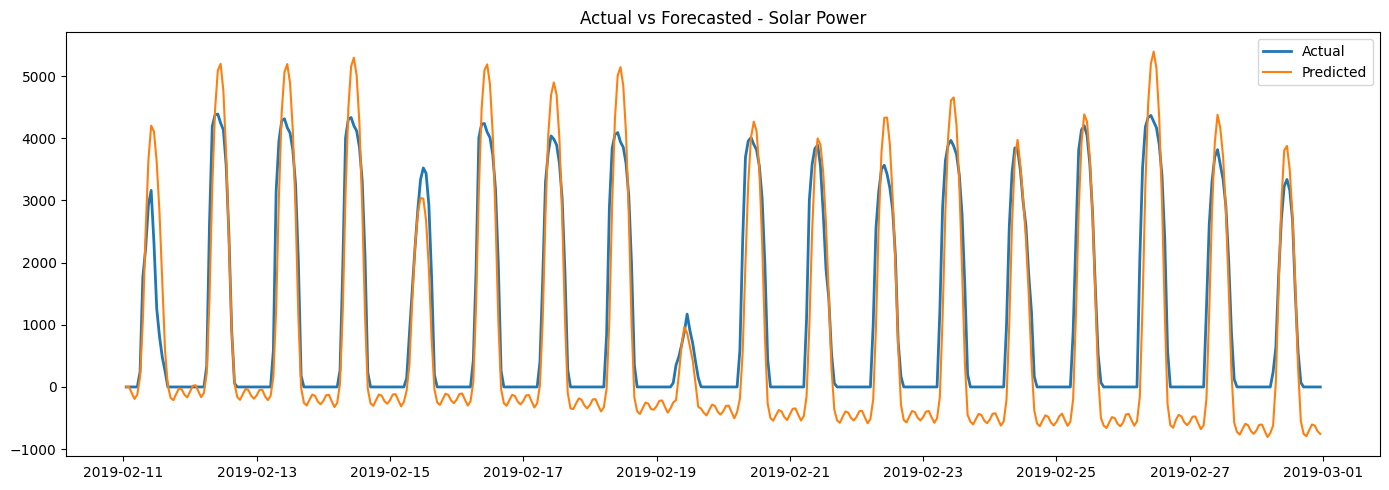

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(test_df['ds'], y_true, label='Actual', linewidth=2)
plt.plot(test_df['ds'], y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs Forecasted - Solar Power")
plt.tight_layout()
plt.show()

In [22]:
future_dates = model.make_future_dataframe(periods=24*7, freq='H')
for col in ['temperature', 'humidity', 'irradiance_ground', 'irradiance_atmos']:
    future_dates[col] = df_model[col].median()
future_forecast = model.predict(future_dates)
future_forecast[['ds', 'yhat']].tail()

C:\Users\avinashsharma01\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds,yhat
1884,2019-02-17 20:00:00,-164.161766
1885,2019-02-17 21:00:00,-187.845517
1886,2019-02-17 22:00:00,-280.953966
1887,2019-02-17 23:00:00,-329.675220
1888,2019-02-18 00:00:00,-277.015020


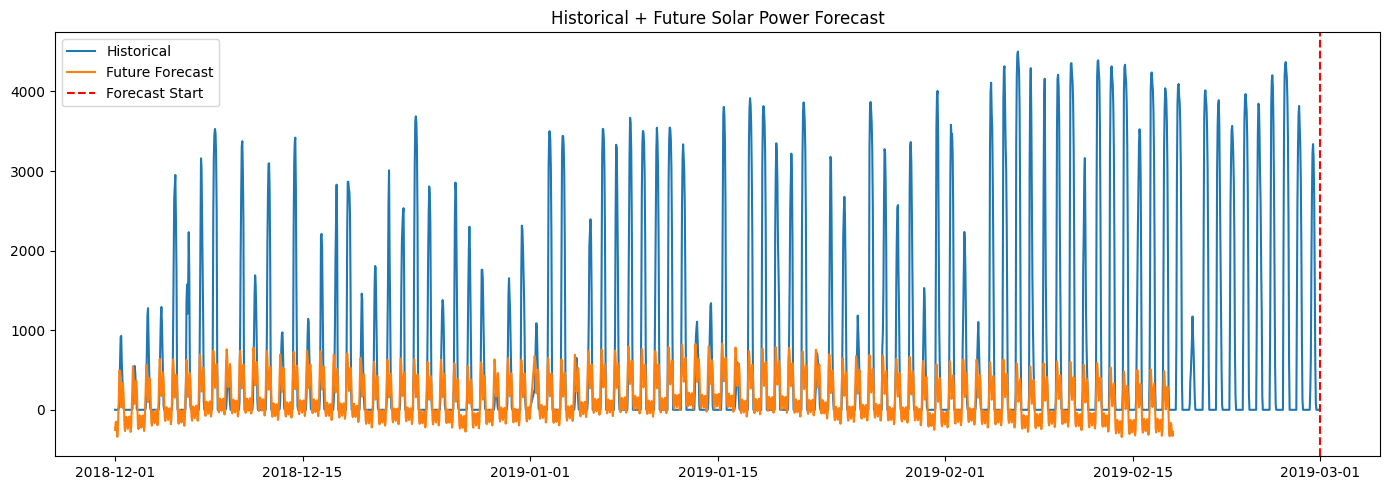

In [23]:
plt.figure(figsize=(14,5))
plt.plot(df_model['ds'], df_model['y'], label='Historical')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future Forecast')
plt.axvline(df_model['ds'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
plt.legend()
plt.title("Historical + Future Solar Power Forecast")
plt.tight_layout()
plt.show()

In [26]:
import joblib
joblib.dump(model, "model.pkl")

['model.pkl']